<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/misc/bayes_tails.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayes tails examples

Based on
- https://colab.research.google.com/github/gerdm/misc/blob/master/2023-09/bayes-tails.ipynb
- https://twitter.com/rlmcelreath/status/1701165075493470644
- https://gist.github.com/bbolker/2a0da634aa13ba2401779158da286af2
- https://twitter.com/Chris_Julliard/status/1701369625294864862

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tensorflow_probability.substrates import jax as tfp

tfd = tfp.distributions

2023-09-12 08:13:13.180116: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
%config InlineBackend.figure_format = "retina"

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [ ]:
def process_posterior(
    eval_domain,
    mean_prior=10.0, mean_likelihood=0.0,
    std_prior=1.0, std_likelihood=1.0,
    df_prior=1000, df_likelihood=1000,
):
    dt = eval_domain[1] - eval_domain[0]
    pr_prior = tfd.StudentT(df_prior, mean_prior, std_prior)
    pr_likelihood = tfd.StudentT(df_likelihood, mean_likelihood, std_likelihood)

    density_prior = pr_prior.prob(eval_domain)
    density_likelihood = pr_likelihood.prob(eval_domain)

    Z = (density_prior * density_likelihood * dt).sum()
    density_posterior = density_prior * density_likelihood / Z

    res = {
        "density-prior": density_prior,
        "density-likelihood": density_likelihood,
        "density-posterior": density_posterior,
    }

    return res

In [ ]:
xrange = jnp.linspace(-5, 15, 1000)
@jax.vmap
def experiment(df_prior, df_likelihood):
    return process_posterior(xrange, df_prior=df_prior, df_likelihood=df_likelihood)

# Degrees of freedom: prior / likelihood
df_configs = jnp.array([
    (1000, 1000),
    (2, 1000),
    (1000, 2),
    (2, 2)
], dtype=jnp.float32)

results = experiment(df_configs[:, 0], df_configs[:, 1])
jax.tree_map(jnp.shape, results)

{'density-likelihood': (4, 1000),
 'density-posterior': (4, 1000),
 'density-prior': (4, 1000)}

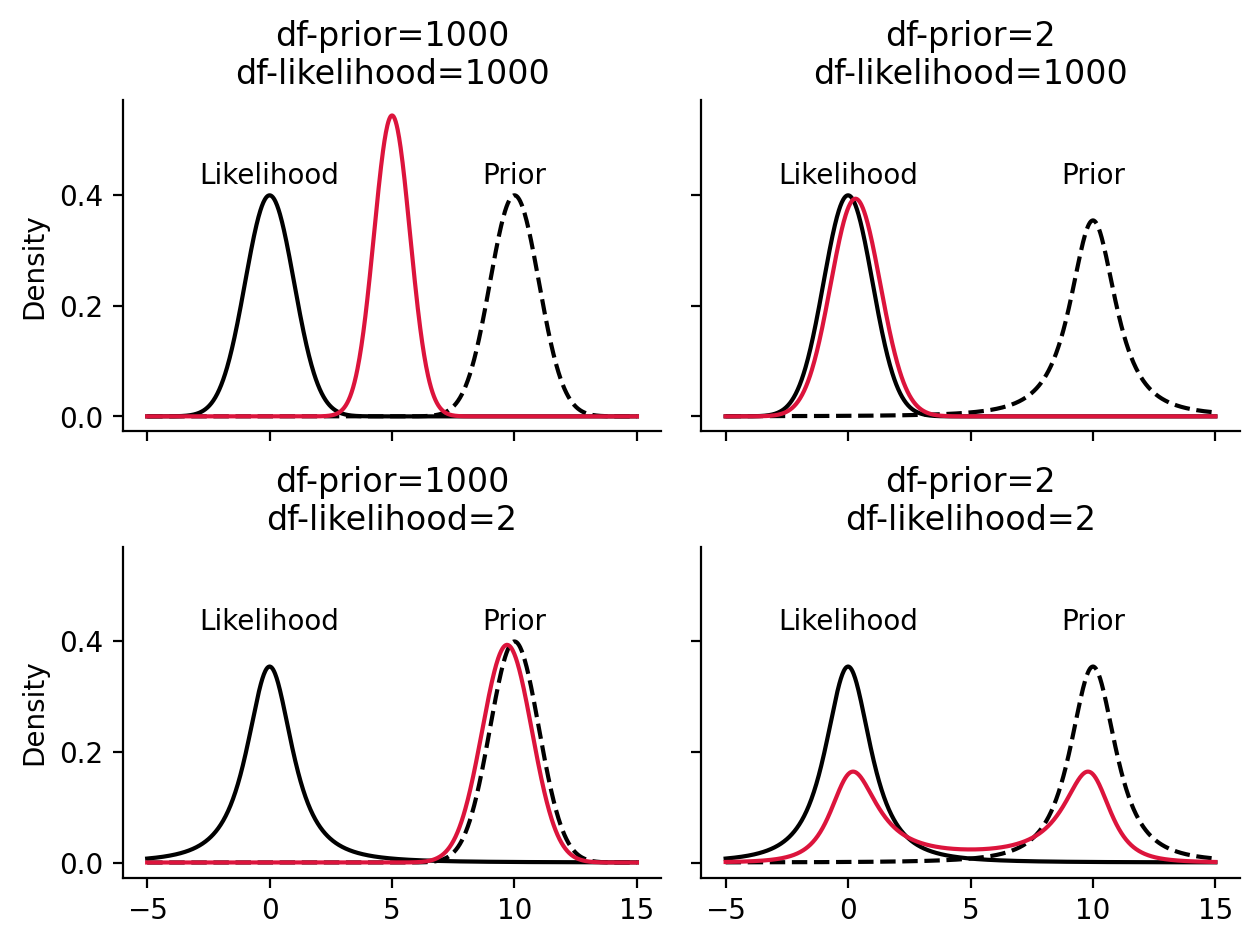

In [ ]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
for i, (axi, config) in enumerate(zip(axs.ravel(), df_configs)):
    df_prior, df_likelihood = config
    dprior = results["density-prior"][i]
    dlikelihood = results["density-likelihood"][i]
    dpost = results["density-posterior"][i]

    axi.plot(xrange, dprior, c="black", linestyle="--")
    axi.plot(xrange, dlikelihood, c="black")
    axi.plot(xrange, dpost, c="crimson")

    axi.set_title(f"df-prior={df_prior.item():0.0f}\ndf-likelihood={df_likelihood.item():0.0f}")
    axi.text(10, 0.42, "Prior", horizontalalignment="center")
    axi.text(0, 0.42, "Likelihood", horizontalalignment="center")

axs[0, 0].set_ylabel("Density")
axs[1, 0].set_ylabel("Density")
plt.tight_layout()